In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_selection import chi2

In [3]:
train_values = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv')
train_labels = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv')
test_values = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Test_Values.csv')

In [4]:
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


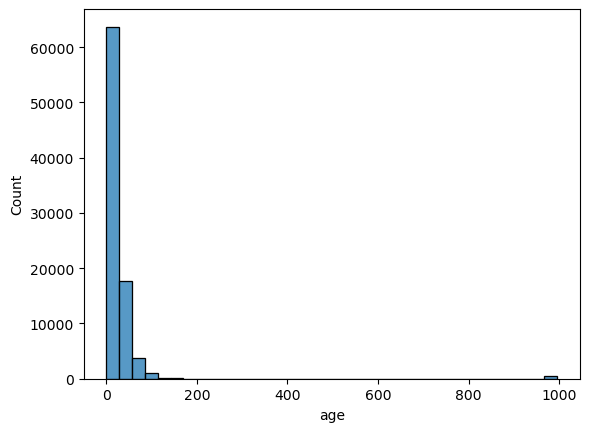

In [5]:
sns.histplot(test_values['age'], bins=35)
scaler = StandardScaler()
train_values['age'] = scaler.fit_transform(np.array(train_values['age']).reshape(-1,1))
#sns.histplot(train_values['age'], bins=35)
building_id = test_values['building_id']

secondary = ['has_secondary_use_agriculture', 'has_secondary_use_hotel',
            'has_secondary_use_rental', 'has_secondary_use_institution',
            'has_secondary_use_school', 'has_secondary_use_industry',
            'has_secondary_use_health_post', 'has_secondary_use_gov_office',
            'has_secondary_use_use_police', 'has_secondary_use_other',
            'has_secondary_use']

binary_values = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
                'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
                'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
                'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_other']

categorical = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
               'other_floor_type', 'position', 'plan_configuration']

drop_columns = ['building_id', 'legal_ownership_status', 'count_floors_pre_eq', 'has_secondary_use_use_police']
train_values = train_values.drop(drop_columns, axis=1)

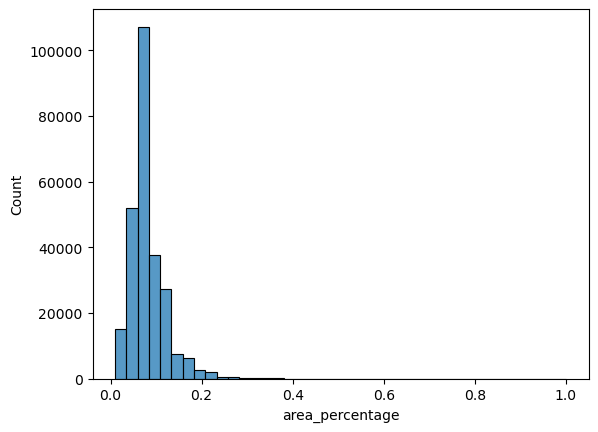

In [6]:
#SCALING THE AGE (EXPERIMENTAL)
scaler = MinMaxScaler()
train_values['age'] = scaler.fit_transform(np.array(train_values['age']).reshape(-1,1))
test_values['age'] = scaler.fit_transform(np.array(test_values['age']).reshape(-1,1))

#Concat Area (EXPERIMENTAL)
train_values['plan_configuration'] = ['d' if plan in ['s', 'c', 'a', 'o', 'm', 'n', 'f'] else plan for plan in train_values['plan_configuration']]
train_values['foundation_type'] = ['i' if foundation == 'h' else foundation for foundation in train_values['foundation_type']]

train_values['height_percentage'] = [height/100 for height in train_values['height_percentage']]
train_values['area_percentage'] = [area/100 for area in train_values['area_percentage']]

sns.histplot(train_values['area_percentage'], bins=40)

categorical_df = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
                  'other_floor_type', 'position', 'plan_configuration']

In [7]:
ohe = OneHotEncoder(sparse_output=False)   
le = LabelEncoder() 
encoded_dataframe = pd.DataFrame()
for i in categorical_df:
    temporary = pd.DataFrame(ohe.fit_transform(np.array(train_values[i]).reshape(-1, 1)))
    temporary.columns = ohe.get_feature_names_out([i])
    encoded_dataframe = pd.concat([encoded_dataframe, temporary], axis=1)
    train_values.drop([i], axis=1, inplace=True)   
    
x = pd.concat([train_values, encoded_dataframe], axis=1)
y = le.fit_transform(train_labels['damage_grade'])

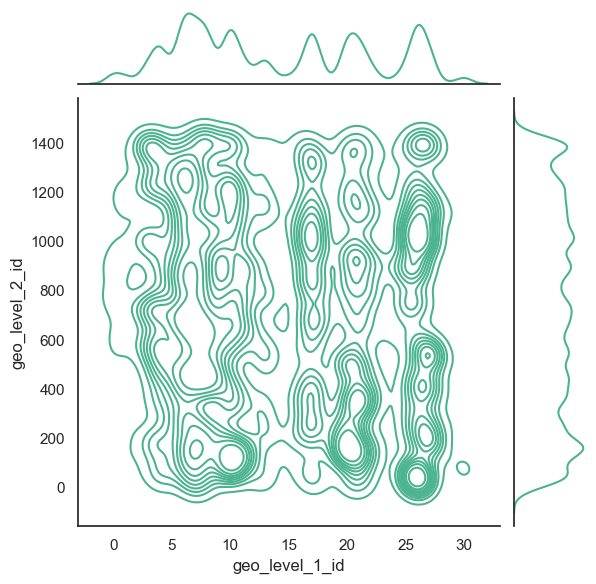

In [8]:
# Plot the geo_levels
sns.set_theme(style='white')
sns.jointplot(x='geo_level_1_id', y='geo_level_2_id', kind="kde", color="#4CB391", data=train_values)

In [9]:
#Finding the correlation between two columns. If it's higher than 70%, then one of them will be dropped.    
def find_high_correlation_columns(df):
    le = LabelEncoder()
    for i in df.columns:
        for j in df.columns:
            if i == j:
                pass
            else:
                if (type(df[i][1]) != str) and (type(df[j][1]) != str):
                    if df[i].corr(df[j])*100 > 70:
                        print(i, j, df[i].corr(df[j])*100)
                elif type(df[i][1]) != str and (type(df[j][1]) == str):
                    if df[i].corr(pd.DataFrame(le.fit_transform(df[j]))[0])*100 > 70:
                        print(i, j, df[i].corr(pd.DataFrame(le.fit_transform(df[j]))[0])*100)
                elif type(df[i][1]) == str and (type(df[j][1]) != str):
                    if df[j].corr(pd.DataFrame(le.fit_transform(df[i]))[0])*100 > 70:
                        print(i, j, df[j].corr(pd.DataFrame(le.fit_transform(df[i]))[0])*100)
                else:
                    if pd.DataFrame(le.fit_transform(df[j]))[0].corr(pd.DataFrame(le.fit_transform(df[i]))[0])*100 > 70:
                        print(i, j, pd.DataFrame(le.fit_transform(df[j]))[0].corr(pd.DataFrame(le.fit_transform(df[i]))[0])*100)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

test_values = test_values.drop(drop_columns, axis=1)

In [11]:
#Concat Area (EXPERIMENTAL)
test_values['plan_configuration'] = ['d' if plan in ['s', 'c', 'a', 'o', 'm', 'n', 'f'] else plan for plan in test_values['plan_configuration']]
test_values['foundation_type'] = ['i' if foundation == 'h' else foundation for foundation in test_values['foundation_type']]

test_values['height_percentage'] = [height/100 for height in test_values['height_percentage']]
test_values['area_percentage'] = [area/100 for area in test_values['area_percentage']]

In [12]:
ohe_ = OneHotEncoder(sparse_output=False)   

encoded_test_dataframe = pd.DataFrame()

In [13]:
for i in categorical_df:
    temporary_test = pd.DataFrame(ohe_.fit_transform(np.array(test_values[i]).reshape(-1, 1)))
    temporary_test.columns = ohe_.get_feature_names_out([i])
    encoded_test_dataframe = pd.concat([encoded_test_dataframe, temporary_test], axis=1)
    test_values.drop([i], axis=1, inplace=True)   
    
p = pd.concat([test_values, encoded_test_dataframe], axis=1)

In [14]:
xgb = XGBClassifier(objective='multi:softmax', gamma=0, alpha=0.1, max_depth=10,
                    colsample_bytree=0.8, subsample=0.8)

In [ ]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print(score)